#**PROYECTO FINAL 2025 - INTELIGENCIA ARTIFICIAL**

In [1]:
# IMPORTS COMPLETOS DEL PROYECTO
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
from datetime import datetime

# Google Colab
from google.colab import drive

# Scikit-learn - Preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Scikit-learn - Model Selection
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate

# Scikit-learn - Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

# Scikit-learn - Metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Scikit-learn - Dimensionality Reduction
from sklearn.decomposition import PCA

# Scikit-learn - Feature Selection
from sklearn.feature_selection import SelectKBest, f_regression

# Scipy - Statistics
from scipy import stats

# SHAP - Explainability
import shap

# Weights & Biases - Experiment Tracking
import wandb

# Joblib - Model Persistence
import joblib

# Configuración
warnings.filterwarnings('ignore')
np.random.seed(42)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
np.random.seed(42)

# ====================================================================
# 1. CARGA Y EXPLORACIÓN INICIAL DE DATOS
# ====================================================================

In [3]:
df = pd.read_csv('dfProductivity_KNN_cleaned.csv')
df = df.drop(columns=['perceived_productivity_score'])
print(f"Dimensiones: {df.shape}")
print(f"Variables: {df.columns.tolist()}")
print("\nInformación general:")
print(df.info())

print("\nEstadísticas descriptivas:")
print(df.describe())

Dimensiones: (30000, 18)
Variables: ['age', 'gender', 'job_type', 'daily_social_media_time', 'social_platform_preference', 'number_of_notifications', 'work_hours_per_day', 'actual_productivity_score', 'stress_level', 'sleep_hours', 'screen_time_before_sleep', 'breaks_during_work', 'uses_focus_apps', 'has_digital_wellbeing_enabled', 'coffee_consumption_per_day', 'days_feeling_burnout_per_month', 'weekly_offline_hours', 'job_satisfaction_score']

Información general:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age                             30000 non-null  int64  
 1   gender                          30000 non-null  object 
 2   job_type                        30000 non-null  object 
 3   daily_social_media_time         30000 non-null  float64
 4   social_platform_preference      30000 non-null  ob

# ====================================================================
# 2. FEATURE ENGINEERING
# ====================================================================


2.1 DISTRIBUCIÓN DE LAS VARIABLES
Variables numéricas (15): ['age', 'daily_social_media_time', 'number_of_notifications', 'work_hours_per_day', 'actual_productivity_score', 'stress_level', 'sleep_hours', 'screen_time_before_sleep', 'breaks_during_work', 'uses_focus_apps', 'has_digital_wellbeing_enabled', 'coffee_consumption_per_day', 'days_feeling_burnout_per_month', 'weekly_offline_hours', 'job_satisfaction_score']
Variables categóricas (3): ['gender', 'job_type', 'social_platform_preference']


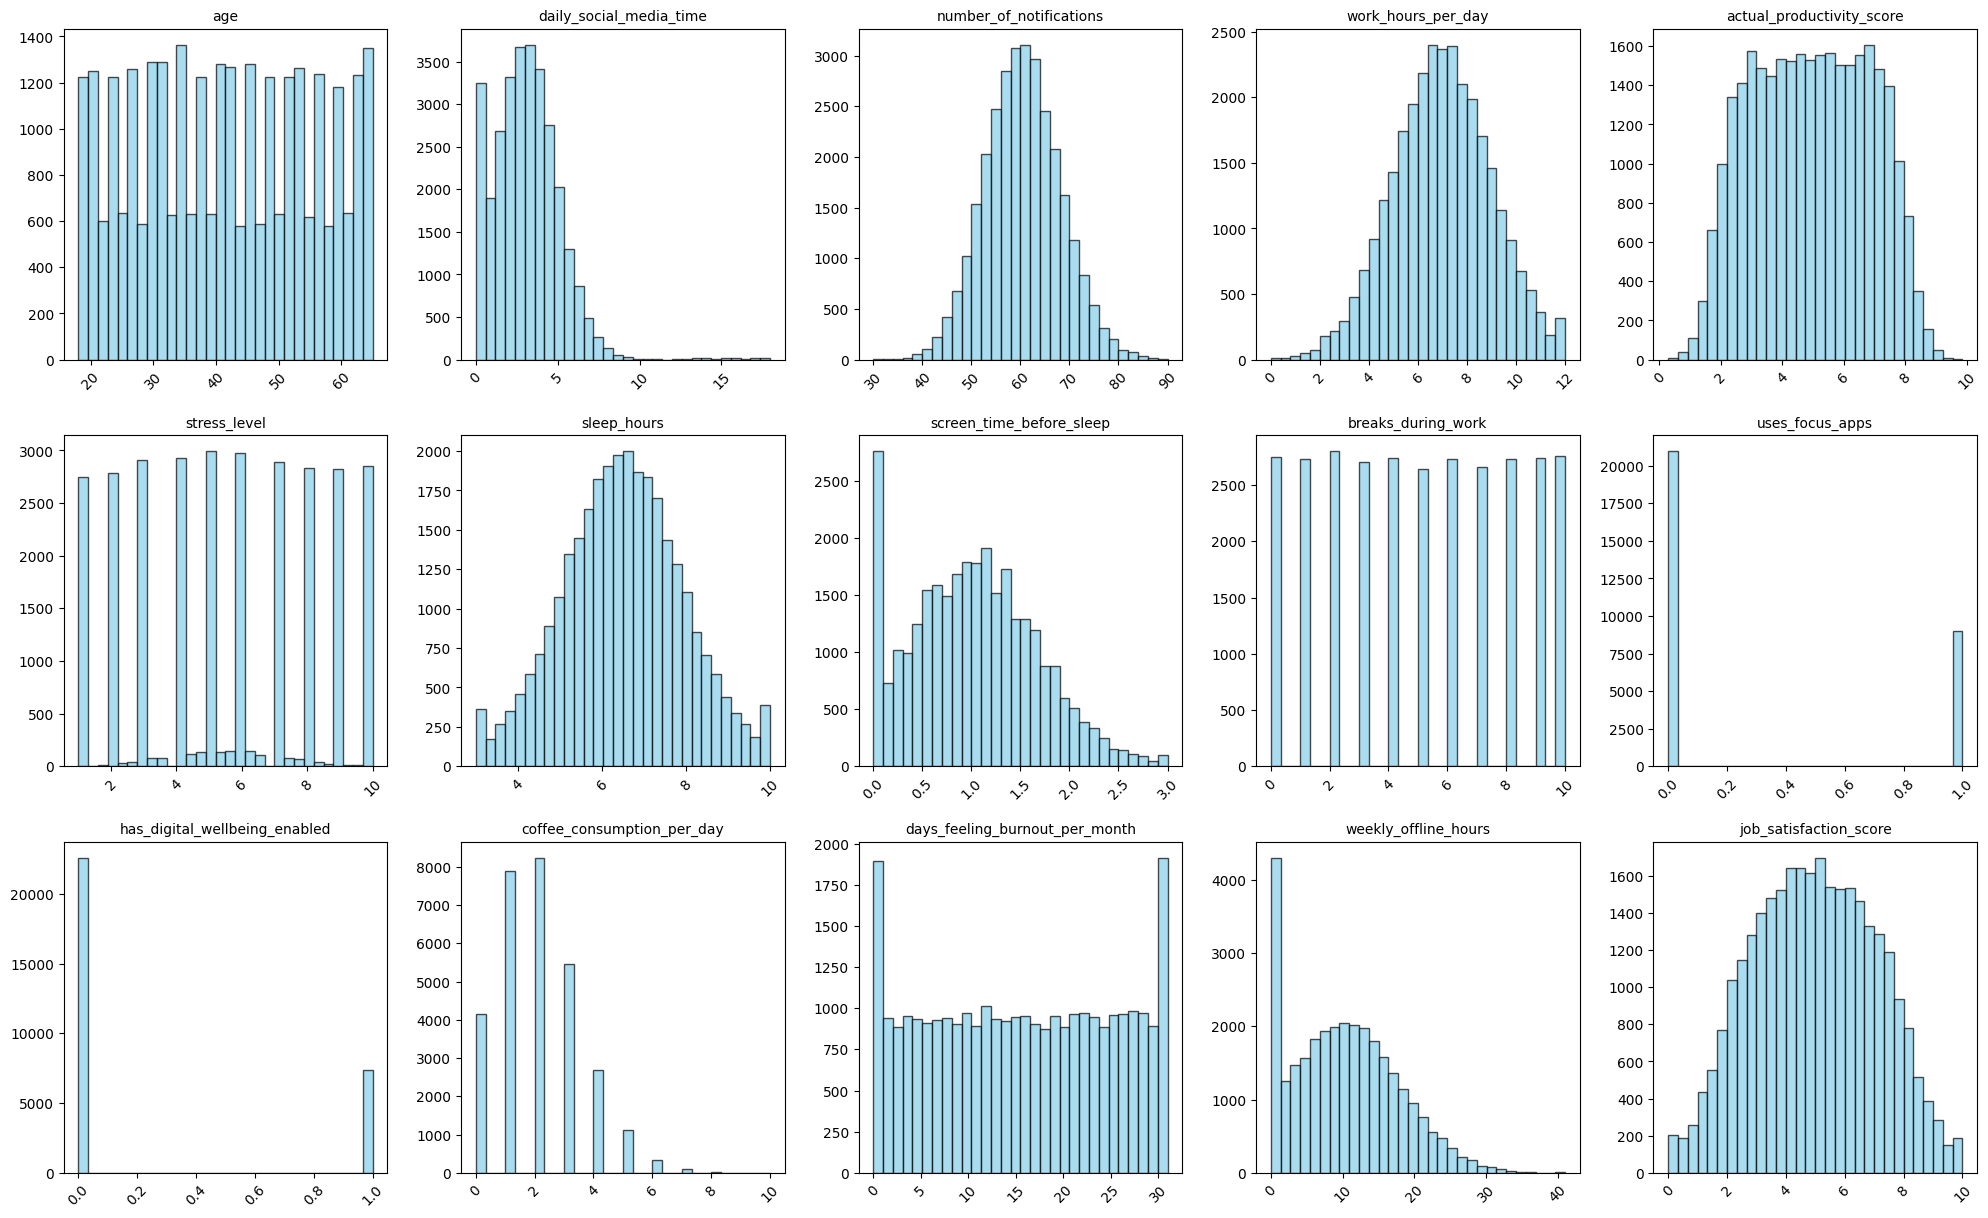


Análisis de asimetría (Skewness):
                      Variable  Skewness        Interpretación
                           age  0.015305             Simétrica
       daily_social_media_time  1.202689           Muy sesgada
       number_of_notifications  0.117736             Simétrica
            work_hours_per_day -0.038135             Simétrica
     actual_productivity_score -0.009185             Simétrica
                  stress_level  0.002230             Simétrica
                   sleep_hours  0.007646             Simétrica
      screen_time_before_sleep  0.309716             Simétrica
            breaks_during_work  0.006698             Simétrica
               uses_focus_apps  0.869282 Moderadamente sesgada
 has_digital_wellbeing_enabled  1.175842           Muy sesgada
    coffee_consumption_per_day  0.674751 Moderadamente sesgada
days_feeling_burnout_per_month -0.007784             Simétrica
          weekly_offline_hours  0.423369             Simétrica
        job_satisfac

In [4]:
# 2.1 DISTRIBUCIÓN DE LAS VARIABLES
print("\n2.1 DISTRIBUCIÓN DE LAS VARIABLES")

# Variables numéricas
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

print(f"Variables numéricas ({len(numeric_cols)}): {numeric_cols}")
print(f"Variables categóricas ({len(categorical_cols)}): {categorical_cols}")

# Visualización de distribuciones
fig, axes = plt.subplots(4, 5, figsize=(20, 16))
axes = axes.ravel()

for i, col in enumerate(numeric_cols):
    if i < len(axes):
        axes[i].hist(df[col].dropna(), bins=30, alpha=0.7, color='skyblue', edgecolor='black')
        axes[i].set_title(f'{col}', fontsize=10)
        axes[i].tick_params(axis='x', rotation=45)

# Ocultar subplots vacíos
for i in range(len(numeric_cols), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.savefig('distribucion_variables.png', dpi=300, bbox_inches='tight')
plt.show()

# Análisis de asimetría
print("\nAnálisis de asimetría (Skewness):")
skewness_data = []
for col in numeric_cols:
    skew_val = df[col].skew()
    skewness_data.append({'Variable': col, 'Skewness': skew_val, 'Interpretación':
                         'Simétrica' if abs(skew_val) < 0.5 else
                         'Moderadamente sesgada' if abs(skew_val) < 1 else 'Muy sesgada'})

skewness_df = pd.DataFrame(skewness_data)
print(skewness_df.to_string(index=False))

**Explicación del proceso**. Una vez visualizadas las distribuciones de las variables se comprueba que hay ciertas características con sesgo (moderados y altos) basándonos en skewness.

Intentamos mitigar esos sesgos de la siguiente forma:


*   Sesgo muy alto: aplicamos función logaritmo a la caracaterística.
*   Sesgo moderado: aplicamos función raíz cuadrada al ser menos agresiva, ya que el sesgo no es tan grave.


ESTUDIO DE CORRELACIONES


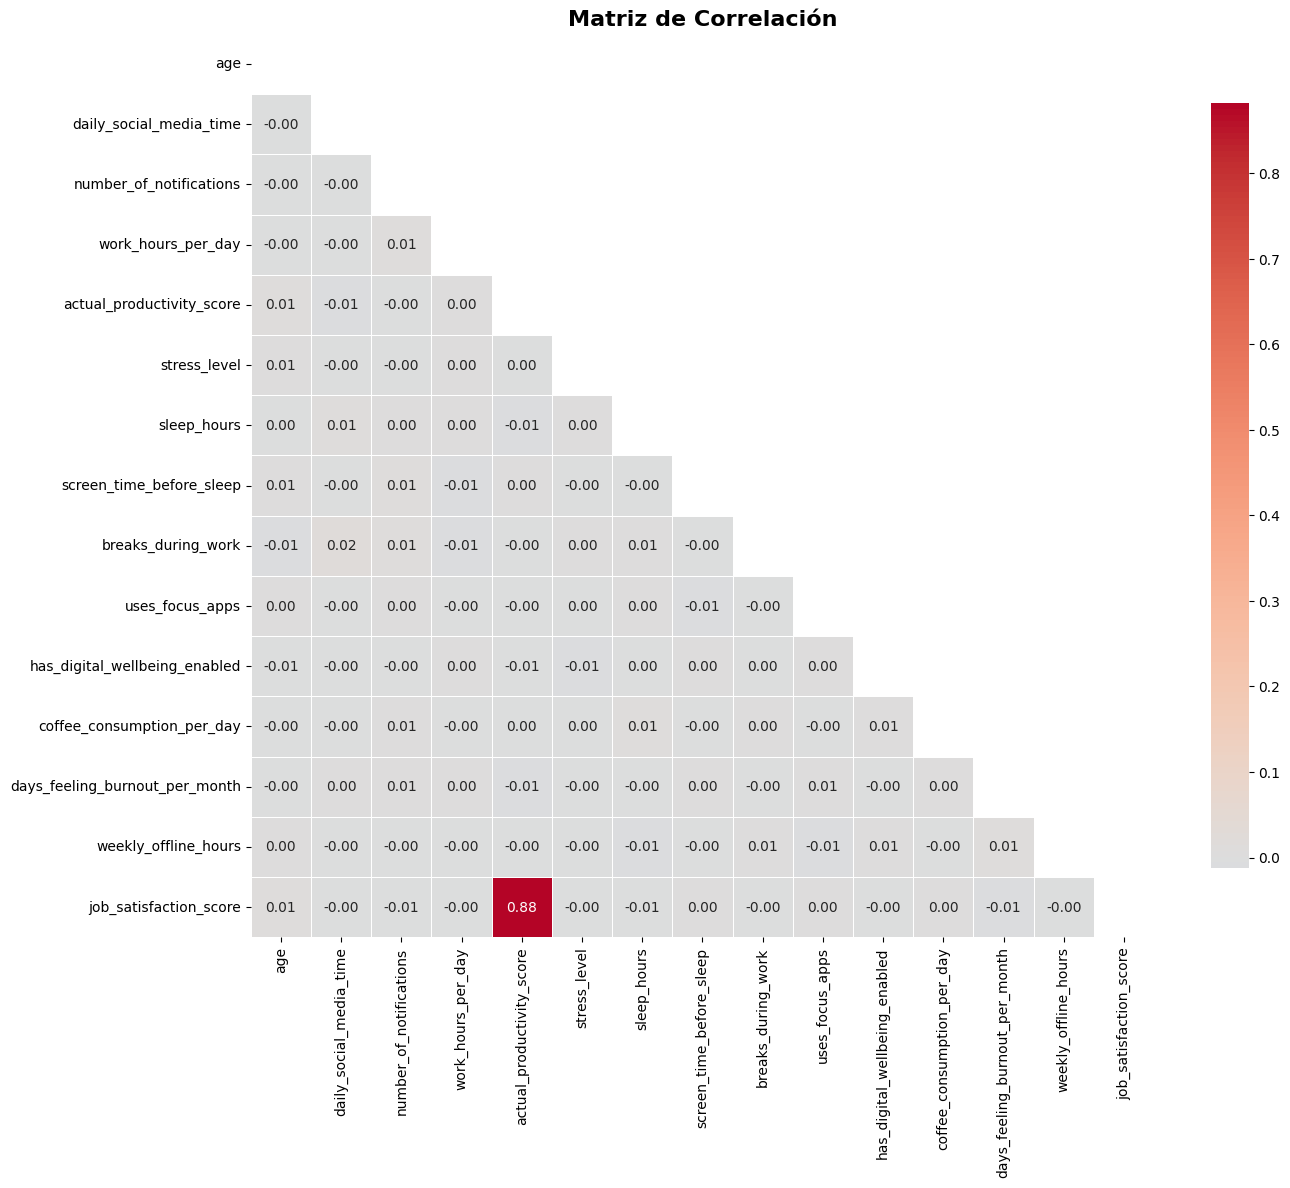


Correlaciones más fuertes con 'actual_productivity_score':
   job_satisfaction_score: 0.882
   days_feeling_burnout_per_month: 0.013
   age: 0.011
   sleep_hours: 0.009
   daily_social_media_time: 0.007
   has_digital_wellbeing_enabled: 0.005
   weekly_offline_hours: 0.005
   breaks_during_work: 0.004
   screen_time_before_sleep: 0.002
   work_hours_per_day: 0.001
   uses_focus_apps: 0.001
   number_of_notifications: 0.001
   coffee_consumption_per_day: 0.000
   stress_level: 0.000


In [5]:
# 2.2 ESTUDIO DE CORRELACIONES
print("\nESTUDIO DE CORRELACIONES")

# Matriz de correlación
correlation_matrix = df[numeric_cols].corr()

# Visualización de la matriz de correlación
plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8}, fmt='.2f')
plt.title('Matriz de Correlación', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('matriz_correlacion.png', dpi=300, bbox_inches='tight')
plt.show()

# Correlaciones más fuertes con la variable objetivo
target_correlations = correlation_matrix['actual_productivity_score'].abs().sort_values(ascending=False)
print(f"\nCorrelaciones más fuertes con 'actual_productivity_score':")
for var, corr in target_correlations.items():
    if var != 'actual_productivity_score':
        print(f"   {var}: {corr:.3f}")

**Interpretación**. Según la matriz de Pearson no se han encontrado muchas relaciones lineales entre las características. Únicamente se ve relación entre actual_productivity, job_satisfaction y perceived_productivity.

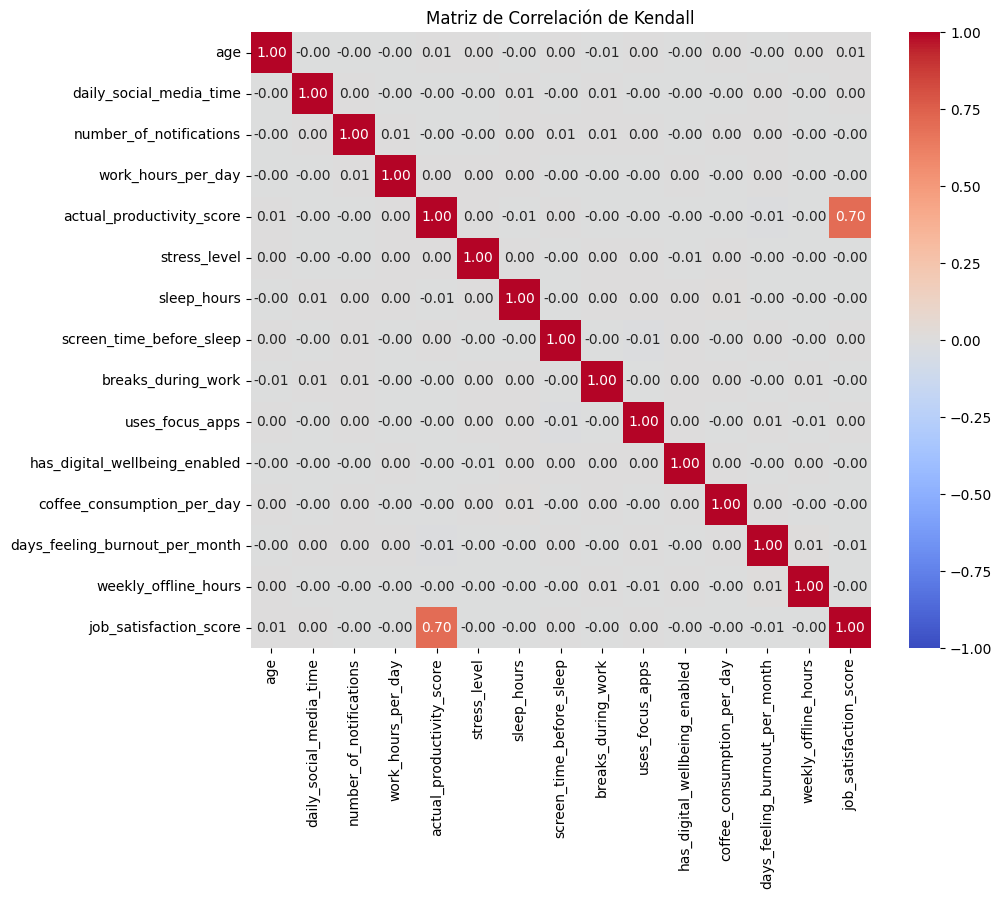

In [6]:
# Se ejecuta Kendall para comprobar relaciones no lineales de features

kendall_corr = df[numeric_cols].corr(method='kendall')
plt.figure(figsize=(10, 8))
sns.heatmap(kendall_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
plt.title('Matriz de Correlación de Kendall')
plt.show()

**Interpretación**. Dado que no se encontró relación lineal con la matriz de Pearson, decidimos ver si con la matriz de Kendall se podrían encontrar relaciones no lineales que no se pudiesen ver a simple vista.

A pesar de hacer la prueba, el resultado es el mismo.


2.3 VALORACIÓN DE REDUCCIÓN DE DIMENSIONALIDAD


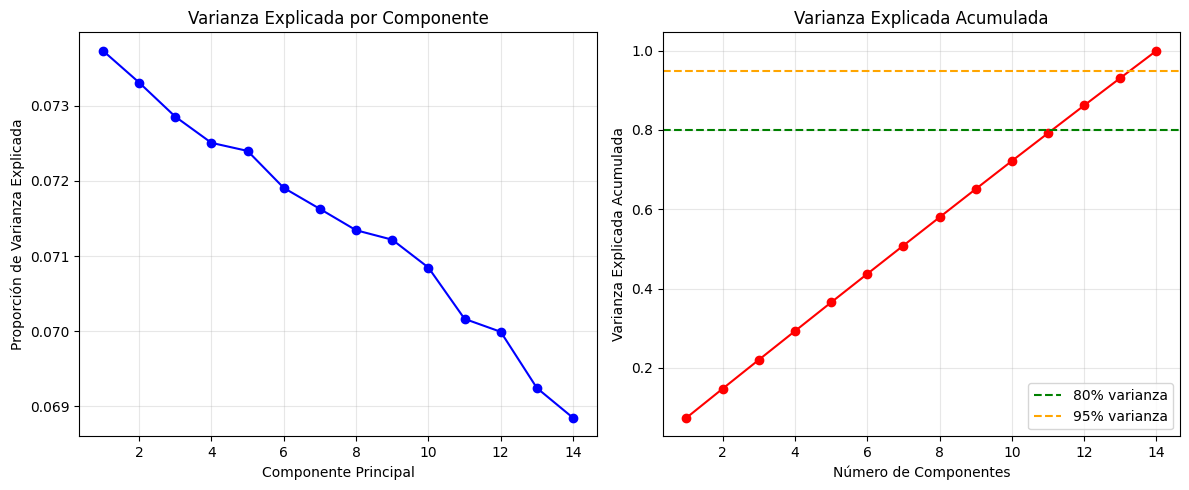

📊 Componentes necesarios para explicar:
   • 80% de la varianza: 12 componentes
   • 95% de la varianza: 14 componentes
   • Total de variables originales: 14


In [7]:
# 2.3 VALORACIÓN DE REDUCCIÓN DE DIMENSIONALIDAD
print("\n2.3 VALORACIÓN DE REDUCCIÓN DE DIMENSIONALIDAD")

# Preparar datos para PCA (solo variables numéricas, excluir target)
X_numeric = df[numeric_cols].drop(['actual_productivity_score'], axis=1)
X_numeric_scaled = StandardScaler().fit_transform(X_numeric)

# Aplicar PCA
pca = PCA()
X_pca = pca.fit_transform(X_numeric_scaled)

# Varianza explicada acumulada
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(12, 5))

# Gráfico de varianza explicada
plt.subplot(1, 2, 1)
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, 'bo-')
plt.title('Varianza Explicada por Componente')
plt.xlabel('Componente Principal')
plt.ylabel('Proporción de Varianza Explicada')
plt.grid(True, alpha=0.3)

# Gráfico de varianza acumulada
plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'ro-')
plt.axhline(y=0.8, color='g', linestyle='--', label='80% varianza')
plt.axhline(y=0.95, color='orange', linestyle='--', label='95% varianza')
plt.title('Varianza Explicada Acumulada')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Explicada Acumulada')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('analisis_pca.png', dpi=300, bbox_inches='tight')
plt.show()

# Encontrar número de componentes para 80% y 95% de varianza
n_components_80 = np.argmax(cumulative_variance >= 0.8) + 1
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1

print(f"📊 Componentes necesarios para explicar:")
print(f"   • 80% de la varianza: {n_components_80} componentes")
print(f"   • 95% de la varianza: {n_components_95} componentes")
print(f"   • Total de variables originales: {len(X_numeric.columns)}")

**Interpretación**. Hemos aplicado PCA para comprobar si de alguna forma podemos reducir la dimensionalidad utilizando el menor número de caracterísicas con la mayor exlicabilidad de la varianza.

Finalmente, el dataset sigue con el mismo número de componentes principales, ya que las 13 cracterísticas numéricas explican el 95% de la varianza total.

In [8]:
# 2.5 FUNCIÓN DE TRANSFORMACIÓN COMPLETA
print("\n2.5 FUNCIÓN DE TRANSFORMACIÓN COMPLETA")

def transform_data(df, target_col='actual_productivity_score', test_mode=False, scaler=None, encoders=None):
    """
    Función completa para transformar datos desde lectura hasta preparación para ML

    Parameters:
    -----------
    df : pandas.DataFrame
        Dataset original
    target_col : str
        Nombre de la variable objetivo
    test_mode : bool
        Si es True, usa transformadores ya ajustados (para datos de test)
    scaler : sklearn.preprocessing.StandardScaler
        Escalador pre-ajustado (solo para test_mode=True)
    encoders : dict
        Diccionario de encoders pre-ajustados (solo para test_mode=True)

    Returns:
    --------
    X_transformed : numpy.array
        Features transformadas
    y : numpy.array or None
        Variable objetivo (None si no está presente)
    scaler : sklearn.preprocessing.StandardScaler
        Escalador ajustado
    encoders : dict
        Diccionario de encoders ajustados
    feature_names : list
        Nombres de las features finales
    """

    df_processed = df.copy()

    # 1. Manejo de valores faltantes (si los hay)
    numeric_cols = df_processed.select_dtypes(include=[np.number]).columns.tolist()
    if target_col in numeric_cols:
        numeric_cols.remove(target_col)

    categorical_cols = df_processed.select_dtypes(include=['object']).columns.tolist()

    # Imputación simple para valores faltantes
    for col in numeric_cols:
        if df_processed[col].isnull().sum() > 0:
            df_processed[col].fillna(df_processed[col].median(), inplace=True)

    for col in categorical_cols:
        if df_processed[col].isnull().sum() > 0:
            df_processed[col].fillna(df_processed[col].mode()[0], inplace=True)

    # 2. Encoding de variables categóricas
    if not test_mode:
        encoders = {}

    encoded_dfs = []

    for col in categorical_cols:
        if not test_mode:
            # Crear y ajustar encoder
            le = LabelEncoder()
            encoded_col = le.fit_transform(df_processed[col])
            encoders[col] = le
        else:
            # Usar encoder pre-ajustado
            le = encoders[col]
            # Manejar categorías no vistas
            encoded_col = []
            for val in df_processed[col]:
                try:
                    encoded_col.append(le.transform([val])[0])
                except ValueError:
                    # Categoría no vista, asignar valor más frecuente
                    encoded_col.append(0)
            encoded_col = np.array(encoded_col)

        encoded_dfs.append(pd.DataFrame({f'{col}_encoded': encoded_col}))

    # 3. Combinar features numéricas y categóricas codificadas
    X = pd.concat([df_processed[numeric_cols]] + encoded_dfs, axis=1)

    # 4. Tratamiento de asimetríia
    print("Aplicando transformaciones de asimetría...")

    # Definir transformaciones basadas en análisis de skewness
    skewed_transformations = {
        # Variables muy sesgadas (|skew| > 1.0) -> log1p
        'daily_social_media_time': 'log1p',
        'has_digital_wellbeing_enabled': 'log1p',

        # Variables moderadamente sesgadas (0.5 < |skew| < 1.0) -> sqrt
        'uses_focus_apps': 'sqrt',
        'coffee_consumption_per_day': 'sqrt'
    }

    transformations_applied = []

    for original_col, transform_type in skewed_transformations.items():
        if original_col in X.columns:
            try:
                if transform_type == 'log1p':
                    # log1p es más estable que log para valores que pueden ser 0
                    X[f'{original_col}_log'] = np.log1p(X[original_col])
                    transformations_applied.append(f'{original_col} -> log1p')

                elif transform_type == 'sqrt':
                    # Asegurar valores no negativos para sqrt
                    X[f'{original_col}_sqrt'] = np.sqrt(np.maximum(0, X[original_col]))
                    transformations_applied.append(f'{original_col} -> sqrt')

            except Exception as e:
                print(f"   ⚠️ Error transformando {original_col}: {e}")

    if not test_mode and transformations_applied:
        print(f"   ✅ Transformaciones aplicadas: {len(transformations_applied)}")
        for transform in transformations_applied:
            print(f"      • {transform}")

    # 5. Crear features adicionales (engineering)
    # Ratios e interacciones útiles
    if 'daily_social_media_time' in X.columns and 'work_hours_per_day' in X.columns:
        X['social_work_ratio'] = X['daily_social_media_time'] / (X['work_hours_per_day'] + 1e-6)

    if 'sleep_hours' in X.columns and 'work_hours_per_day' in X.columns:
        X['sleep_work_ratio'] = X['sleep_hours'] / (X['work_hours_per_day'] + 1e-6)

    if 'daily_social_media_time' in X.columns and 'screen_time_before_sleep' in X.columns:
        X['total_screen_time'] = X['daily_social_media_time'] + X['screen_time_before_sleep']

    if 'perceived_productivity_score' in X.columns:
        # Solo crear si no es la variable objetivo
        if target_col != 'perceived_productivity_score':
            actual_score = X.get('actual_productivity_score', 0)
            X['productivity_gap'] = X['perceived_productivity_score'] - actual_score

    if 'stress_level' in X.columns and 'job_satisfaction_score' in X.columns:
        X['stress_satisfaction_ratio'] = X['stress_level'] / (X['job_satisfaction_score'] + 1e-6)

    # Variables booleanas como numéricas (si no fueron transformadas ya)
    bool_cols = ['uses_focus_apps', 'has_digital_wellbeing_enabled']
    for col in bool_cols:
        if col in df_processed.columns and col in X.columns:
            X[col] = X[col].astype(int)

    # 6. SELECCIÓN DE FEATURES MEJORADA
    # Eliminar variables originales si fueron transformadas por asimetría
    original_skewed_vars = list(skewed_transformations.keys())

    # Mantener tanto originales como transformadas por ahora,
    # la correlación alta las eliminará si es necesario
    print(f"   Features antes de selección: {len(X.columns)}")

    # Eliminar correlaciones muy altas
    correlation_matrix = X.corr().abs()
    upper_triangle = correlation_matrix.where(
        np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
    )

    # Encontrar features con correlación > 0.95
    high_corr_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.95)]

    # Preferir versiones transformadas sobre originales
    features_to_drop = []
    for feature in high_corr_features:
        # Si la feature original tiene una versión transformada, eliminar la original
        base_name = feature.replace('_log', '').replace('_sqrt', '')
        if base_name in original_skewed_vars:
            if feature == base_name:  # Es la versión original
                # Verificar si existe la transformada
                transformed_exists = any(f'{base_name}_log' in X.columns or f'{base_name}_sqrt' in X.columns)
                if transformed_exists:
                    features_to_drop.append(feature)
                    continue
        features_to_drop.append(feature)

    # Eliminar duplicados
    features_to_drop = list(set(features_to_drop))
    X = X.drop(columns=features_to_drop)

    if features_to_drop:
        print(f"   Features eliminadas por alta correlación: {len(features_to_drop)}")
        print(f"   Features finales: {len(X.columns)}")

    # 7. Escalado de features
    if not test_mode:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
    else:
        X_scaled = scaler.transform(X)

    # 8. Preparar variable objetivo
    y = None
    if target_col in df_processed.columns:
        y = df_processed[target_col].values

    feature_names = X.columns.tolist()

    return X_scaled, y, scaler, encoders, feature_names

# ACTUALIZAR LA PRUEBA DE LA FUNCIÓN
print("\nProbando función de transformación actualizada...")
X_transformed, y, scaler_fitted, encoders_fitted, feature_names = transform_data(df)

print(f"\n✅ Transformación completada:")
print(f"   • Shape de X: {X_transformed.shape}")
print(f"   • Shape de y: {y.shape}")
print(f"   • Features finales: {len(feature_names)}")
print(f"\nFeatures creadas:")
for i, name in enumerate(feature_names):
  print(f"   {i+1:2d}. {name}")


2.5 FUNCIÓN DE TRANSFORMACIÓN COMPLETA

Probando función de transformación actualizada...
Aplicando transformaciones de asimetría...
   ✅ Transformaciones aplicadas: 4
      • daily_social_media_time -> log1p
      • has_digital_wellbeing_enabled -> log1p
      • uses_focus_apps -> sqrt
      • coffee_consumption_per_day -> sqrt
   Features antes de selección: 25
   Features eliminadas por alta correlación: 3
   Features finales: 22

✅ Transformación completada:
   • Shape de X: (30000, 22)
   • Shape de y: (30000,)
   • Features finales: 22

Features creadas:
    1. age
    2. daily_social_media_time
    3. number_of_notifications
    4. work_hours_per_day
    5. stress_level
    6. sleep_hours
    7. screen_time_before_sleep
    8. breaks_during_work
    9. uses_focus_apps
   10. has_digital_wellbeing_enabled
   11. coffee_consumption_per_day
   12. days_feeling_burnout_per_month
   13. weekly_offline_hours
   14. job_satisfaction_score
   15. gender_encoded
   16. job_type_encoded


# ====================================================================
# 3. ENTRENAMIENTO DE MODELOS
# ====================================================================

In [9]:
# 3.1 DIVISIÓN DE DATOS
print("\n3.1 DIVISIÓN DE DATOS")

X_train, X_test, y_train, y_test = train_test_split(
    X_transformed, y, test_size=0.2, random_state=42, stratify=None
)

print(f"División completada:")
print(f"   • Entrenamiento: {X_train.shape[0]} muestras")
print(f"   • Test: {X_test.shape[0]} muestras")


3.1 DIVISIÓN DE DATOS
División completada:
   • Entrenamiento: 24000 muestras
   • Test: 6000 muestras


In [10]:
# 3.2 DEFINICIÓN DE MODELOS
print("\n3.2 DEFINICIÓN DE MODELOS")

models = {
    'Linear Regression': {
        'model': LinearRegression(),
        'params': {}
    },
    'Random Forest': {
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5, 10]
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingRegressor(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.05, 0.1, 0.15],
            'max_depth': [3, 5, 7]
        }
    },
    'Neural Network': {
        'model': MLPRegressor(random_state=42, max_iter=1000),
        'params': {
            'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
            'activation': ['relu', 'tanh'],
            'alpha': [0.001, 0.01, 0.1],
            'learning_rate': ['adaptive']
        }
    }
}

print(f"Modelos a entrenar: {list(models.keys())}")

# # 3.2 DEFINICIÓN DE MODELOS (VERSIÓN ULTRA-RÁPIDA)
# print("\n3.2 DEFINICIÓN DE MODELOS (OPTIMIZADO PARA VELOCIDAD)")

# # Opción 1: SIN GridSearch (RECOMENDADO para 30k filas)
# models = {
#     'Linear Regression': {
#         'model': LinearRegression(),
#         'params': {}
#     },
#     'Random Forest': {
#         'model': RandomForestRegressor(
#             n_estimators=100,           # Valor fijo razonable
#             max_depth=15,              # Valor fijo razonable
#             min_samples_split=5,       # Valor fijo razonable
#             random_state=42,
#             n_jobs=-1
#         ),
#         'params': {}
#     },
#     'Gradient Boosting': {
#         'model': GradientBoostingRegressor(
#             n_estimators=100,          # Valor fijo razonable
#             learning_rate=0.1,         # Valor fijo razonable
#             max_depth=5,               # Valor fijo razonable
#             random_state=42
#         ),
#         'params': {}
#     },
#     'Neural Network': {
#         'model': MLPRegressor(
#             hidden_layer_sizes=(100,), # Arquitectura fija razonable
#             activation='relu',         # Activación fija
#             alpha=0.01,               # Regularización fija
#             max_iter=300,             # Menos iteraciones
#             early_stopping=True,      # Para en convergencia
#             random_state=42
#         ),
#         'params': {}
#     }
# }



3.2 DEFINICIÓN DE MODELOS
Modelos a entrenar: ['Linear Regression', 'Random Forest', 'Gradient Boosting', 'Neural Network']


In [13]:
# 3.3 INICIALIZAR WANDB
wandb.init(
    project="redes-sociales-productividad",
    name=f"experimento-{datetime.now().strftime('%Y%m%d-%H%M%S')}",
    entity='aapradodarriba-ntt-data',
    config={
        "dataset_size": len(df),
        "test_size": 0.2,
        "random_state": 42,
        "target_variable": "actual_productivity_score",
        "problem_type": "regression",
        "models": list(models.keys()),
        "features_count": len(feature_names)
    },
    tags=["productividad", "redes-sociales", "proyecto-final"]
)

print(f"Weights & Biases inicializado")
print(f"Dashboard: {wandb.run.url}")

# Log información del dataset
wandb.log({
    "dataset/total_samples": len(df),
    "dataset/features": len(df.columns),
    "dataset/target_mean": df['actual_productivity_score'].mean(),
    "dataset/target_std": df['actual_productivity_score'].std(),
    "dataset/unique_values": len(df['actual_productivity_score'].unique())
})

dataset/features,▁
dataset/target_mean,▁
dataset/target_std,▁
dataset/total_samples,▁
dataset/unique_values,▁
dataset/features,18
dataset/target_mean,4.95532
dataset/target_std,1.86582
dataset/total_samples,30000
dataset/unique_values,1998


Weights & Biases inicializado
Dashboard: https://wandb.ai/aapradodarriba-ntt-data/redes-sociales-productividad/runs/wkrfjvfa


In [15]:
# 3.4 ENTRENAMIENTO UNIFICADO CON WANDB
print("\n3.4 ENTRENAMIENTO Y EVALUACIÓN UNIFICADO")

results = {}
all_metrics = {}

for name, model_config in models.items():
    print(f"\n🔄 Entrenando {name}...")
    start_time = time.time()

    # GridSearch o entrenamiento directo
    if model_config['params']:
        print(f"   🔍 Búsqueda de hiperparámetros...")
        grid_search = GridSearchCV(
            model_config['model'],
            model_config['params'],
            cv=3,
            scoring='r2',
            n_jobs=-1,
            verbose=1
        )

        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_

        # Log hiperparámetros
        # wandb.log({f"{name}/best_cv_score": grid_search.best_score_})
        print(f"   Mejores parámetros: {best_params}")
        print(f"   Mejor CV score: {grid_search.best_score_:.4f}")

    else:
        best_model = model_config['model']
        best_model.fit(X_train, y_train)
        best_params = "No hyperparameter tuning"

    training_time = time.time() - start_time

    # Predicciones
    y_train_pred = best_model.predict(X_train)
    y_test_pred = best_model.predict(X_test)

    # Métricas completas
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    overfitting = train_r2 - test_r2

    # Cross-validation detallada
    cv_scores = cross_validate(
        best_model, X_train, y_train,
        cv=5,
        scoring=['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error'],
        return_train_score=True
    )

    cv_r2_mean = cv_scores['test_r2'].mean()
    cv_r2_std = cv_scores['test_r2'].std()
    cv_mse_mean = -cv_scores['test_neg_mean_squared_error'].mean()

    # Compilar métricas
    metrics = {
        f"{name}/train_mse": train_mse,
        f"{name}/train_r2": train_r2,
        f"{name}/train_mae": train_mae,
        f"{name}/test_mse": test_mse,
        f"{name}/test_r2": test_r2,
        f"{name}/test_mae": test_mae,
        f"{name}/cv_r2_mean": cv_r2_mean,
        f"{name}/cv_r2_std": cv_r2_std,
        f"{name}/cv_mse_mean": cv_mse_mean,
        f"{name}/overfitting": overfitting,
        f"{name}/training_time": training_time
    }

    # Log métricas a wandb
    wandb.log(metrics)

    # Guardar en results (formato original para compatibilidad)
    results[name] = {
        'model': best_model,
        'best_params': best_params,
        'train_mse': train_mse,
        'test_mse': test_mse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'cv_mse': cv_mse_mean,
        'cv_std': cv_r2_std,
        'training_time': training_time,
        'y_train_pred': y_train_pred,
        'y_test_pred': y_test_pred
    }

    # Visualizaciones automáticas
    fig_pred = plt.figure(figsize=(15, 5))

    # Predicciones vs Reales
    plt.subplot(1, 3, 1)
    plt.scatter(y_test, y_test_pred, alpha=0.5, s=1)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Valores Reales')
    plt.ylabel('Predicciones')
    plt.title(f'{name} - Predicciones vs Reales')
    plt.grid(True, alpha=0.3)

    # Residuos
    plt.subplot(1, 3, 2)
    residuals = y_test - y_test_pred
    plt.scatter(y_test_pred, residuals, alpha=0.5, s=1)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicciones')
    plt.ylabel('Residuos')
    plt.title(f'{name} - Análisis de Residuos')
    plt.grid(True, alpha=0.3)

    # Distribución de errores
    plt.subplot(1, 3, 3)
    plt.hist(residuals, bins=30, alpha=0.7, edgecolor='black')
    plt.axvline(residuals.mean(), color='red', linestyle='--',
                label=f'Media: {residuals.mean():.3f}')
    plt.xlabel('Residuos')
    plt.ylabel('Frecuencia')
    plt.title(f'{name} - Distribución de Errores')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    wandb.log({f"analysis/{name.lower().replace(' ', '_')}": wandb.Image(fig_pred)})
    plt.close()

    # Feature importance si está disponible
    if hasattr(best_model, 'feature_importances_'):
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': best_model.feature_importances_
        }).sort_values('importance', ascending=False)

        # Log tabla
        wandb.log({f"feature_importance_table/{name.lower().replace(' ', '_')}":
                   wandb.Table(dataframe=importance_df.head(15))})

        # Gráfico de importancia
        fig_imp = plt.figure(figsize=(12, 8))
        top_features = importance_df.head(15)
        plt.barh(range(len(top_features)), top_features['importance'])
        plt.yticks(range(len(top_features)), top_features['feature'])
        plt.xlabel('Importancia')
        plt.title(f'Feature Importance - {name}')
        plt.gca().invert_yaxis()
        plt.grid(True, axis='x', alpha=0.3)
        plt.tight_layout()

        wandb.log({f"feature_importance_plot/{name.lower().replace(' ', '_')}": wandb.Image(fig_imp)})
        plt.close()

    # Mostrar resultados
    print(f"   ✅ {name} completado:")
    print(f"      • R² Test: {test_r2:.4f}")
    print(f"      • MSE Test: {test_mse:.4f}")
    print(f"      • Overfitting: {overfitting:.4f}")
    print(f"      • CV R²: {cv_r2_mean:.4f} (±{cv_r2_std:.4f})")
    print(f"      • Tiempo: {training_time:.1f}s")



3.4 ENTRENAMIENTO Y EVALUACIÓN UNIFICADO

🔄 Entrenando Linear Regression...
   ✅ Linear Regression completado:
      • R² Test: 0.7762
      • MSE Test: 0.7747
      • Overfitting: 0.0033
      • CV R²: 0.7788 (±0.0037)
      • Tiempo: 0.0s

🔄 Entrenando Random Forest...
   🔍 Búsqueda de hiperparámetros...
Fitting 3 folds for each of 27 candidates, totalling 81 fits
   Mejores parámetros: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}
   Mejor CV score: 0.7847
   ✅ Random Forest completado:
      • R² Test: 0.7848
      • MSE Test: 0.7449
      • Overfitting: 0.0548
      • CV R²: 0.7850 (±0.0038)
      • Tiempo: 285.9s

🔄 Entrenando Gradient Boosting...
   🔍 Búsqueda de hiperparámetros...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
   Mejores parámetros: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
   Mejor CV score: 0.7874
   ✅ Gradient Boosting completado:
      • R² Test: 0.7867
      • MSE Test: 0.7382
      • Overfitting: 0.0051
 

In [16]:
# 3.5 COMPARACIÓN FINAL Y SELECCIÓN DEL MEJOR MODELO
print("\n3.5 ANÁLISIS FINAL Y SELECCIÓN")

# Crear tabla de comparación
comparison_data = []
for name, result in results.items():
    comparison_data.append({
        'modelo': name,
        'test_r2': result['test_r2'],
        'test_mse': result['test_mse'],
        'test_mae': result['test_mae'],
        'overfitting': result['train_r2'] - result['test_r2'],
        'cv_r2_mean': result.get('cv_mse', 0),  # Usando cv_mse como proxy
        'training_time': result['training_time']
    })

comparison_df = pd.DataFrame(comparison_data)

# Log tabla comparativa
wandb.log({"final/model_comparison": wandb.Table(dataframe=comparison_df)})

# Selección del mejor modelo (criterios múltiples)
selection_criteria = {}
for name, result in results.items():
    score = (
        result['test_r2'] * 0.4 +  # 40% R² en test
        (1 - result['test_mse'] / max([r['test_mse'] for r in results.values()])) * 0.3 +
        (1 - abs(result['train_r2'] - result['test_r2'])) * 0.3  # 30% anti-overfitting
    )
    selection_criteria[name] = score

best_model_name = max(selection_criteria.keys(), key=lambda k: selection_criteria[k])
best_result = results[best_model_name]

# Gráfico comparativo final
fig_final = plt.figure(figsize=(16, 10))

# R² Comparison
plt.subplot(2, 3, 1)
plt.bar(comparison_df['modelo'], comparison_df['test_r2'], color='skyblue')
plt.title('R² en Test')
plt.xticks(rotation=45)
plt.ylabel('R²')
plt.grid(True, alpha=0.3)

# MSE Comparison
plt.subplot(2, 3, 2)
plt.bar(comparison_df['modelo'], comparison_df['test_mse'], color='lightcoral')
plt.title('MSE en Test')
plt.xticks(rotation=45)
plt.ylabel('MSE')
plt.grid(True, alpha=0.3)

# Overfitting
plt.subplot(2, 3, 3)
colors = ['red' if x > 0.05 else 'green' for x in comparison_df['overfitting']]
plt.bar(comparison_df['modelo'], comparison_df['overfitting'], color=colors, alpha=0.7)
plt.title('Overfitting (Train R² - Test R²)')
plt.xticks(rotation=45)
plt.ylabel('Diferencia R²')
plt.axhline(y=0.05, color='red', linestyle='--', alpha=0.7, label='Umbral 5%')
plt.legend()
plt.grid(True, alpha=0.3)

# Training Time
plt.subplot(2, 3, 4)
plt.bar(comparison_df['modelo'], comparison_df['training_time'], color='lightgreen')
plt.title('Tiempo de Entrenamiento')
plt.xticks(rotation=45)
plt.ylabel('Segundos')
plt.grid(True, alpha=0.3)

# Ranking final
plt.subplot(2, 3, 5)
sorted_models = sorted(selection_criteria.items(), key=lambda x: x[1], reverse=True)
models_sorted = [x[0] for x in sorted_models]
scores_sorted = [x[1] for x in sorted_models]
colors = ['gold' if model == best_model_name else 'lightgray' for model in models_sorted]
plt.bar(models_sorted, scores_sorted, color=colors)
plt.title('Ranking Final (Score Combinado)')
plt.xticks(rotation=45)
plt.ylabel('Score')
plt.grid(True, alpha=0.3)

# Summary del mejor modelo
plt.subplot(2, 3, 6)
summary_text = f"""MEJOR MODELO: {best_model_name}

MÉTRICAS:
- R² Test: {best_result['test_r2']:.4f}
- MSE Test: {best_result['test_mse']:.4f}
- MAE Test: {best_result['test_mae']:.4f}
- Overfitting: {abs(best_result['train_r2'] - best_result['test_r2']):.4f}

TIEMPO: {best_result['training_time']:.1f}s
SCORE: {selection_criteria[best_model_name]:.4f}"""

plt.text(0.05, 0.95, summary_text, transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top', fontfamily='monospace')
plt.axis('off')

plt.tight_layout()
wandb.log({"final/comparison_dashboard": wandb.Image(fig_final)})
plt.close()

# Summary para wandb
wandb.summary.update({
    "best_model": best_model_name,
    "best_test_r2": best_result['test_r2'],
    "best_test_mse": best_result['test_mse'],
    "best_overfitting": abs(best_result['train_r2'] - best_result['test_r2']),
    "total_training_time": sum([r['training_time'] for r in results.values()]),
    "experiment_completed": True
})

print(f"\nEXPERIMENTO COMPLETADO!")
print(f"Dashboard: {wandb.run.url}")
print(f"\nRESULTADO FINAL:")
print(f"   Mejor modelo: {best_model_name}")
print(f"   R² en test: {best_result['test_r2']:.4f}")
print(f"   MSE en test: {best_result['test_mse']:.4f}")
print(f"   Overfitting: {abs(best_result['train_r2'] - best_result['test_r2']):.4f}")

# Finalizar wandb
# wandb.finish()


3.5 ANÁLISIS FINAL Y SELECCIÓN

EXPERIMENTO COMPLETADO!
Dashboard: https://wandb.ai/aapradodarriba-ntt-data/redes-sociales-productividad/runs/wkrfjvfa

RESULTADO FINAL:
   Mejor modelo: Gradient Boosting
   R² en test: 0.7867
   MSE en test: 0.7382
   Overfitting: 0.0051


ANÁLISIS SHAP - Gradient Boosting


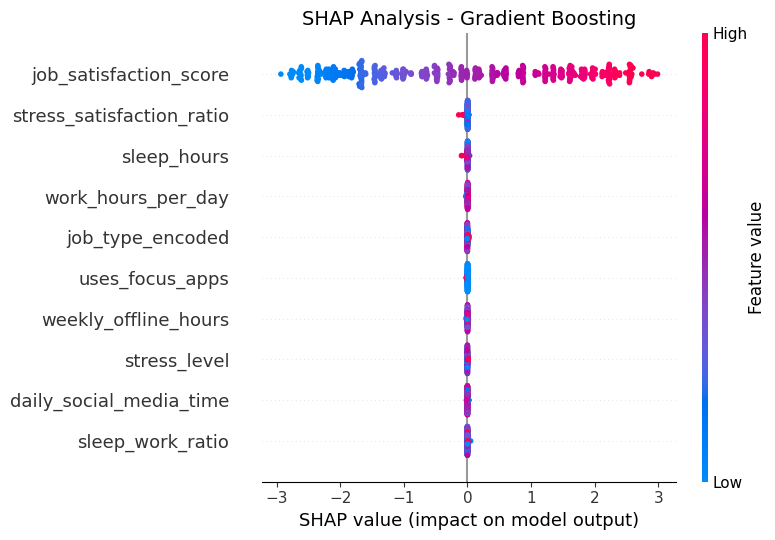


TOP 10 FEATURES - ANÁLISIS SHAP:
Feature                   Importancia  Impacto Promedio
-------------------------------------------------------
job_satisfaction_score    1.4241       -0.0554  ↓ Disminuye
stress_satisfaction_ratio 0.0050       0.0013   ↑ Aumenta
sleep_hours               0.0046       -0.0000  ↓ Disminuye
work_hours_per_day        0.0043       -0.0001  ↓ Disminuye
job_type_encoded          0.0033       0.0005   ↑ Aumenta
uses_focus_apps           0.0032       0.0001   ↑ Aumenta
weekly_offline_hours      0.0030       -0.0002  ↓ Disminuye
stress_level              0.0025       -0.0001  ↓ Disminuye
daily_social_media_time   0.0017       -0.0001  ↓ Disminuye
sleep_work_ratio          0.0014       -0.0000  ↓ Disminuye


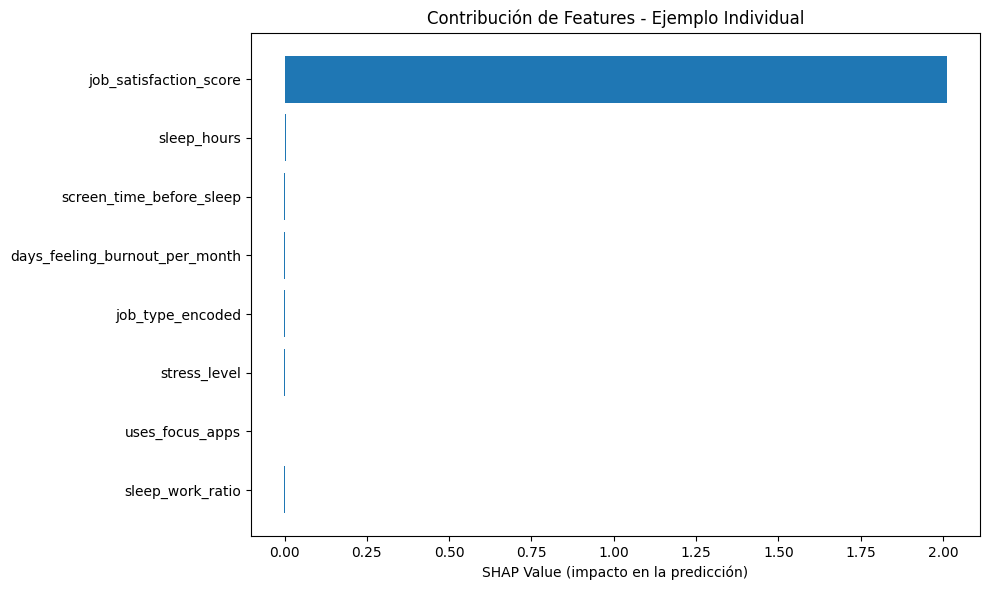


INSIGHTS CLAVE:
Factores que DISMINUYEN productividad:
      • job_satisfaction_score: -0.055


In [17]:
# ANÁLISIS SHAP
import shap
import numpy as np

# Solo para modelos tree-based (Random Forest, Gradient Boosting)
if best_model_name in ['Random Forest', 'Gradient Boosting']:
    print(f"ANÁLISIS SHAP - {best_model_name}")

    # 1. Crear explainer
    best_model_obj = results[best_model_name]['model']
    explainer = shap.TreeExplainer(best_model_obj)

    # 2. Calcular SHAP values (muestra pequeña para velocidad)
    sample_size = min(500, len(X_test))
    X_sample = X_test[:sample_size]
    shap_values = explainer.shap_values(X_sample)

    # 3. Obtener nombres de features (CORRECCIÓN AQUÍ)
    # Opción A: Si tienes feature_names guardado
    try:
        feature_names = feature_names  # Si ya existe
    except:
        # Opción B: Crear nombres genéricos
        feature_names = [f'feature_{i}' for i in range(X_sample.shape[1])]

    # 4. GRÁFICO PRINCIPAL - Summary Plot
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values, X_sample,
                     feature_names=feature_names,
                     max_display=10, show=False)
    plt.title(f'SHAP Analysis - {best_model_name}', fontsize=14)
    plt.tight_layout()
    plt.savefig('shap_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 5. TOP FEATURES con dirección
    shap_importance = np.abs(shap_values).mean(0)
    shap_df = pd.DataFrame({
        'feature': feature_names,
        'shap_importance': shap_importance,
        'avg_impact': np.mean(shap_values, axis=0)
    }).sort_values('shap_importance', ascending=False)

    print(f"\nTOP 10 FEATURES - ANÁLISIS SHAP:")
    print(f"{'Feature':<25} {'Importancia':<12} {'Impacto Promedio':<15}")
    print("-" * 55)
    for i, row in shap_df.head(10).iterrows():
        direction = "↑ Aumenta" if row['avg_impact'] > 0 else "↓ Disminuye"
        print(f"{row['feature']:<25} {row['shap_importance']:<12.4f} {row['avg_impact']:<8.4f} {direction}")

    # 6. EJEMPLO INDIVIDUAL (Waterfall) - VERSIÓN SIMPLIFICADA
    middle_idx = len(shap_values) // 2
    plt.figure(figsize=(10, 6))

    # Bar plot simple en lugar de waterfall si da problemas
    top_features_idx = np.argsort(np.abs(shap_values[middle_idx]))[-8:]
    plt.barh(range(len(top_features_idx)), shap_values[middle_idx][top_features_idx])
    plt.yticks(range(len(top_features_idx)), [feature_names[i] for i in top_features_idx])
    plt.xlabel('SHAP Value (impacto en la predicción)')
    plt.title('Contribución de Features - Ejemplo Individual')
    plt.tight_layout()
    plt.savefig('shap_individual.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 7. INSIGHTS CLAVE
    print(f"\nINSIGHTS CLAVE:")
    # Features que más aumentan productividad
    positive_features = shap_df[shap_df['avg_impact'] > 0.01].head(3)
    negative_features = shap_df[shap_df['avg_impact'] < -0.01].head(3)

    if len(positive_features) > 0:
        print(f"Factores que AUMENTAN productividad:")
        for _, row in positive_features.iterrows():
            print(f"      • {row['feature']}: +{row['avg_impact']:.3f}")

    if len(negative_features) > 0:
        print(f"Factores que DISMINUYEN productividad:")
        for _, row in negative_features.iterrows():
            print(f"      • {row['feature']}: {row['avg_impact']:.3f}")

else:
    print("SHAP solo disponible para Random Forest y Gradient Boosting")

In [18]:
# # 3.9 VALIDACIÓN CRUZADA DETALLADA
print("\n3.9 VALIDACIÓN CRUZADA DETALLADA")

from sklearn.model_selection import cross_validate

# Realizar validación cruzada más detallada para el mejor modelo
scoring_metrics = ['neg_mean_squared_error', 'r2', 'neg_mean_absolute_error']
cv_results = cross_validate(
    results[best_model_name ]['model'],
    X_train, y_train,
    cv=5,
    scoring=scoring_metrics,
    return_train_score=True
)

print(f"VALIDACIÓN CRUZADA DETALLADA - {best_model_name }:")
for metric in scoring_metrics:
    train_scores = cv_results[f'train_{metric}']
    test_scores = cv_results[f'test_{metric}']

    if 'neg_' in metric:
        train_scores = -train_scores
        test_scores = -test_scores
        metric_name = metric.replace('neg_', '').upper()
    else:
        metric_name = metric.upper()

    print(f"    {metric_name}:")
    print(f"      Train: {train_scores.mean():.4f} (±{train_scores.std():.4f})")
    print(f"      Val:   {test_scores.mean():.4f} (±{test_scores.std():.4f})")


3.9 VALIDACIÓN CRUZADA DETALLADA
VALIDACIÓN CRUZADA DETALLADA - Gradient Boosting:
    MEAN_SQUARED_ERROR:
      Train: 0.7233 (±0.0027)
      Val:   0.7404 (±0.0113)
    R2:
      Train: 0.7925 (±0.0009)
      Val:   0.7876 (±0.0038)
    MEAN_ABSOLUTE_ERROR:
      Train: 0.6732 (±0.0020)
      Val:   0.6811 (±0.0076)



3.10 NESTED CROSS-VALIDATION

🚀 INICIANDO NESTED CROSS-VALIDATION

🔄 Configuración de Nested CV:
   • Folds externos (evaluación): 5
   • Folds internos (optimización): 3
   • Modelos a evaluar: 4
   • Total de entrenamientos: 60

🚀 NESTED CV: Linear Regression
⏳ Ejecutando nested cross-validation...

📊 RESULTADOS - Linear Regression:
   R² (test):     0.7783 ± 0.0026
   RMSE (test):   0.8783 ± 0.0025
   MAE (test):    0.6992 ± 0.0028
   Overfitting:   0.0005 ± 0.0033
   Tiempo total:  0.1s

🚀 NESTED CV: Random Forest
⏳ Ejecutando nested cross-validation...

📊 RESULTADOS - Random Forest:
   R² (test):     0.7856 ± 0.0027
   RMSE (test):   0.8639 ± 0.0032
   MAE (test):    0.6824 ± 0.0043
   Overfitting:   0.0509 ± 0.0029
   Tiempo total:  1204.7s

   🔍 Estabilidad de hiperparámetros:
      • max_depth: 10 ✅ (estable)
      • min_samples_split: 10 (80% de los folds)
      • n_estimators: 200 ✅ (estable)

🚀 NESTED CV: Gradient Boosting
⏳ Ejecutando nested cross-validation...

📊 RESULTAD

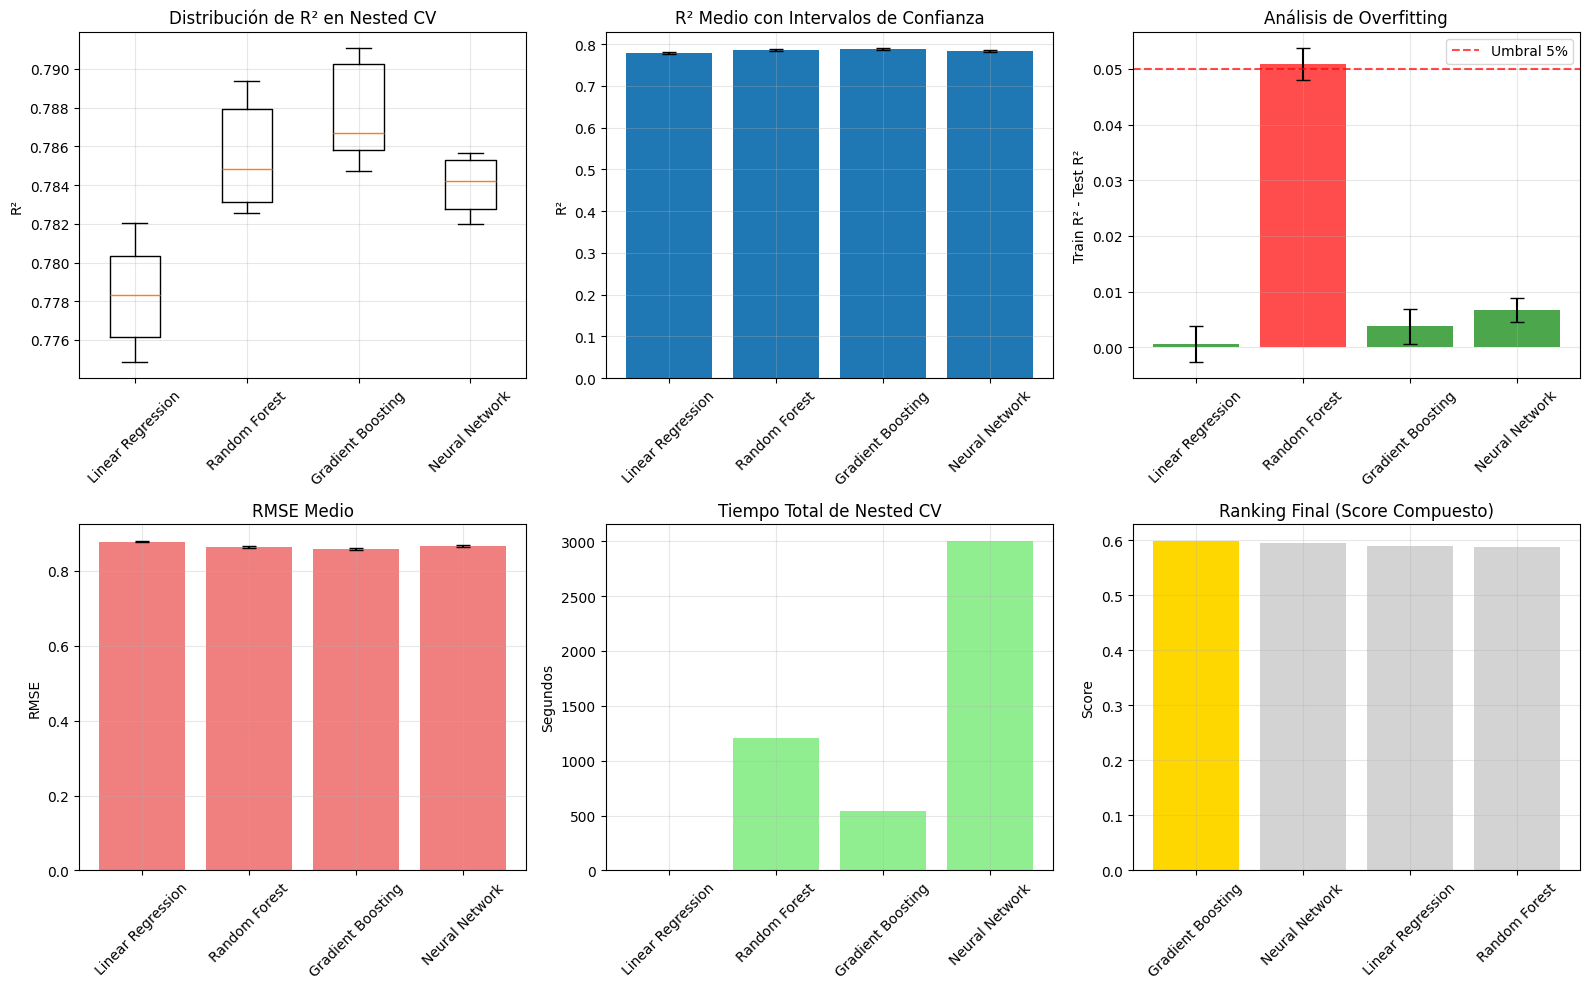


🏆 MEJOR MODELO SEGÚN NESTED CV: Gradient Boosting
   • R² medio: 0.7877 ± 0.0025
   • RMSE medio: 0.8595 ± 0.0027
   • Overfitting: 0.0038 ± 0.0031

ANÁLISIS DE IMPORTANCIA DE FEATURES - NESTED CV

📊 Random Forest:

   Top 10 Features más importantes (promedio en CV):
   Feature                        Importancia  Std        CV%       
   -----------------------------------------------------------------
   job_satisfaction_score         0.9447       0.0017     0.2     % ✅
   screen_time_before_sleep       0.0050       0.0002     4.7     % ✅
   sleep_hours                    0.0049       0.0002     3.8     % ✅
   stress_satisfaction_ratio      0.0047       0.0003     5.5     % ✅
   weekly_offline_hours           0.0046       0.0001     2.7     % ✅
   sleep_work_ratio               0.0045       0.0001     3.2     % ✅
   work_hours_per_day             0.0044       0.0001     2.4     % ✅
   number_of_notifications        0.0038       0.0001     3.2     % ✅
   age                          

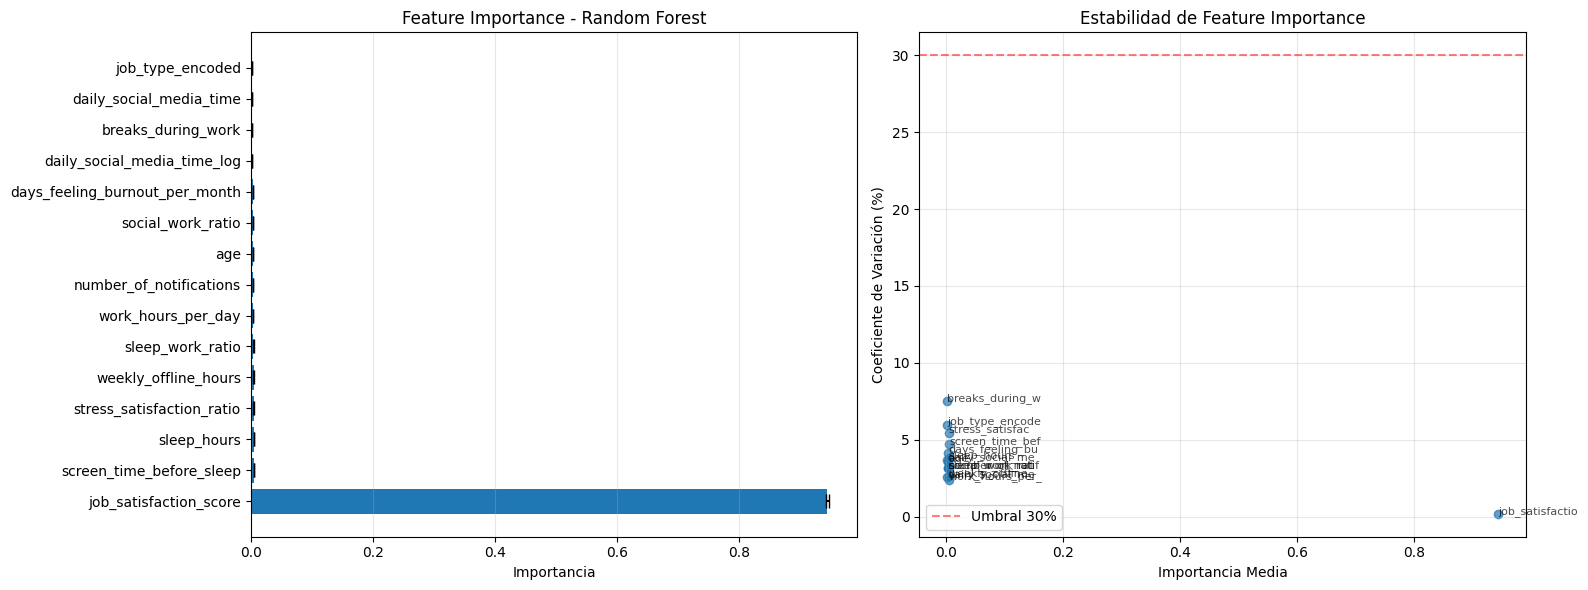


📊 Gradient Boosting:

   Top 10 Features más importantes (promedio en CV):
   Feature                        Importancia  Std        CV%       
   -----------------------------------------------------------------
   job_satisfaction_score         0.9980       0.0001     0.0     % ✅
   stress_satisfaction_ratio      0.0005       0.0001     28.6    % ✅
   sleep_work_ratio               0.0002       0.0001     42.8    % ⚠️
   sleep_hours                    0.0002       0.0001     30.2    % ⚠️
   screen_time_before_sleep       0.0001       0.0000     33.4    % ⚠️
   weekly_offline_hours           0.0001       0.0000     38.4    % ⚠️
   social_work_ratio              0.0001       0.0001     52.3    % ⚠️
   work_hours_per_day             0.0001       0.0000     45.8    % ⚠️
   social_platform_preference_encoded 0.0001       0.0000     32.4    % ⚠️
   number_of_notifications        0.0001       0.0000     23.3    % ✅


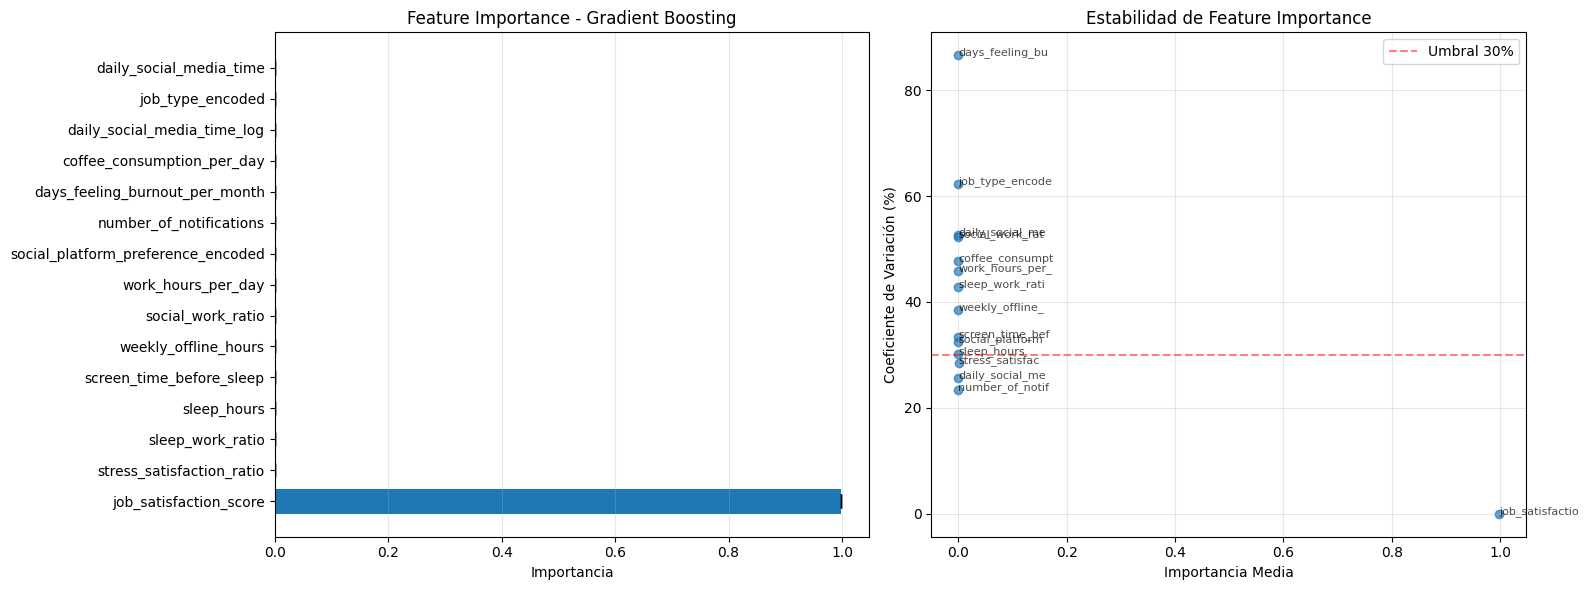


COMPARACIÓN: NESTED CV vs EVALUACIÓN SIMPLE

Mejor modelo según evaluación simple: Gradient Boosting
   R² en test: 0.7867

Mejor modelo según nested CV: Gradient Boosting
   R² medio en nested CV: 0.7877 ± 0.0025

✅ Ambos métodos coinciden en el mejor modelo!

💾 Resultados de nested CV guardados en 'nested_cv_results.pkl'


Gradient Boosting/cv_mse_mean,▁
Gradient Boosting/cv_r2_mean,▁
Gradient Boosting/cv_r2_std,▁
Gradient Boosting/overfitting,▁
Gradient Boosting/test_mae,▁
Gradient Boosting/test_mse,▁
Gradient Boosting/test_r2,▁
Gradient Boosting/train_mae,▁
Gradient Boosting/train_mse,▁
Gradient Boosting/train_r2,▁
Gradient Boosting/training_time,▁



✅ NESTED CROSS-VALIDATION COMPLETADO!
   Total tiempo de ejecución: 4752.6s


In [19]:
# ====================================================================
# 3.10 NESTED CROSS-VALIDATION COMPLETO
# ====================================================================

print("\n" + "="*70)
print("3.10 NESTED CROSS-VALIDATION")
print("="*70)

from sklearn.model_selection import KFold, GridSearchCV, cross_validate
import time
import numpy as np
import pandas as pd

def perform_nested_cv(X, y, models, feature_names, inner_cv=3, outer_cv=5, n_jobs=-1):
    """
    Implementa nested cross-validation para múltiples modelos.

    Parameters:
    -----------
    X : array-like
        Features transformadas
    y : array-like
        Variable objetivo
    models : dict
        Diccionario con modelos y sus parámetros
    feature_names : list
        Nombres de las features
    inner_cv : int
        Número de folds para CV interno (optimización de hiperparámetros)
    outer_cv : int
        Número de folds para CV externo (evaluación del modelo)
    n_jobs : int
        Número de cores a usar

    Returns:
    --------
    nested_results : dict
        Resultados completos del nested CV
    """

    # Configurar los folds
    inner_cv_splitter = KFold(n_splits=inner_cv, shuffle=True, random_state=42)
    outer_cv_splitter = KFold(n_splits=outer_cv, shuffle=True, random_state=42)

    nested_results = {}

    # Log a wandb el inicio del nested CV
    wandb.log({
        "nested_cv/started": True,
        "nested_cv/inner_folds": inner_cv,
        "nested_cv/outer_folds": outer_cv,
        "nested_cv/total_evaluations": inner_cv * outer_cv * len(models)
    })

    print(f"\n🔄 Configuración de Nested CV:")
    print(f"   • Folds externos (evaluación): {outer_cv}")
    print(f"   • Folds internos (optimización): {inner_cv}")
    print(f"   • Modelos a evaluar: {len(models)}")
    print(f"   • Total de entrenamientos: {inner_cv * outer_cv * len(models)}")

    for model_name, model_config in models.items():
        print(f"\n{'='*60}")
        print(f"🚀 NESTED CV: {model_name}")
        print(f"{'='*60}")

        start_time = time.time()

        # Si hay parámetros para optimizar, usar GridSearchCV
        if model_config['params']:
            # GridSearchCV para el loop interno
            grid_search = GridSearchCV(
                estimator=model_config['model'],
                param_grid=model_config['params'],
                cv=inner_cv_splitter,
                scoring='r2',
                n_jobs=n_jobs,
                verbose=0
            )
            model_to_evaluate = grid_search
        else:
            # Si no hay parámetros, usar el modelo directamente
            model_to_evaluate = model_config['model']

        # Métricas múltiples para evaluación
        scoring_metrics = {
            'r2': 'r2',
            'neg_mse': 'neg_mean_squared_error',
            'neg_mae': 'neg_mean_absolute_error',
            'neg_rmse': 'neg_root_mean_squared_error'
        }

        # Nested Cross-Validation
        print("⏳ Ejecutando nested cross-validation...")
        nested_scores = cross_validate(
            model_to_evaluate, X, y,
            cv=outer_cv_splitter,
            scoring=scoring_metrics,
            return_train_score=True,
            return_estimator=True,
            n_jobs=n_jobs
        )

        # Procesar resultados
        test_r2 = nested_scores['test_r2']
        test_rmse = np.sqrt(-nested_scores['test_neg_mse'])
        test_mae = -nested_scores['test_neg_mae']
        train_r2 = nested_scores['train_r2']

        # Extraer mejores parámetros de cada fold (si se usó GridSearch)
        best_params_per_fold = []
        feature_importances_per_fold = []

        if model_config['params']:
            for estimator in nested_scores['estimator']:
                best_params_per_fold.append(estimator.best_params_)

                # Extraer feature importances si están disponibles
                if hasattr(estimator.best_estimator_, 'feature_importances_'):
                    feature_importances_per_fold.append(estimator.best_estimator_.feature_importances_)

        # Calcular estadísticas
        results = {
            'model_name': model_name,
            'test_r2_mean': test_r2.mean(),
            'test_r2_std': test_r2.std(),
            'test_r2_scores': test_r2,
            'test_rmse_mean': test_rmse.mean(),
            'test_rmse_std': test_rmse.std(),
            'test_mae_mean': test_mae.mean(),
            'test_mae_std': test_mae.std(),
            'train_r2_mean': train_r2.mean(),
            'train_r2_std': train_r2.std(),
            'overfitting_mean': (train_r2 - test_r2).mean(),
            'overfitting_std': (train_r2 - test_r2).std(),
            'fit_times': nested_scores['fit_time'],
            'total_time': time.time() - start_time,
            'best_params_per_fold': best_params_per_fold,
            'feature_importances_per_fold': feature_importances_per_fold
        }

        nested_results[model_name] = results

        # Log a wandb
        wandb.log({
            f"nested_cv/{model_name}/test_r2_mean": results['test_r2_mean'],
            f"nested_cv/{model_name}/test_r2_std": results['test_r2_std'],
            f"nested_cv/{model_name}/test_rmse_mean": results['test_rmse_mean'],
            f"nested_cv/{model_name}/test_mae_mean": results['test_mae_mean'],
            f"nested_cv/{model_name}/overfitting_mean": results['overfitting_mean'],
            f"nested_cv/{model_name}/total_time": results['total_time']
        })

        # Imprimir resumen
        print(f"\n📊 RESULTADOS - {model_name}:")
        print(f"   R² (test):     {results['test_r2_mean']:.4f} ± {results['test_r2_std']:.4f}")
        print(f"   RMSE (test):   {results['test_rmse_mean']:.4f} ± {results['test_rmse_std']:.4f}")
        print(f"   MAE (test):    {results['test_mae_mean']:.4f} ± {results['test_mae_std']:.4f}")
        print(f"   Overfitting:   {results['overfitting_mean']:.4f} ± {results['overfitting_std']:.4f}")
        print(f"   Tiempo total:  {results['total_time']:.1f}s")

        # Análisis de estabilidad de hiperparámetros
        if best_params_per_fold:
            print(f"\n   🔍 Estabilidad de hiperparámetros:")
            analyze_param_stability(best_params_per_fold)

    return nested_results

def analyze_param_stability(best_params_list):
    """Analiza la estabilidad de los hiperparámetros entre folds."""
    if not best_params_list:
        return

    # Obtener todos los parámetros únicos
    all_params = set()
    for params in best_params_list:
        all_params.update(params.keys())

    for param in sorted(all_params):
        values = [fold_params.get(param) for fold_params in best_params_list]
        unique_values = list(set(values))

        if len(unique_values) == 1:
            print(f"      • {param}: {unique_values[0]} ✅ (estable)")
        else:
            value_counts = pd.Series(values).value_counts()
            most_common = value_counts.index[0]
            stability_pct = (value_counts.iloc[0] / len(values)) * 100
            print(f"      • {param}: {most_common} ({stability_pct:.0f}% de los folds)")

def compare_nested_cv_results(nested_results):
    """
    Compara los resultados del nested CV y crea visualizaciones.
    """
    print("\n" + "="*70)
    print("COMPARACIÓN DE RESULTADOS - NESTED CV")
    print("="*70)

    # Crear DataFrame comparativo
    comparison_data = []
    for model_name, results in nested_results.items():
        comparison_data.append({
            'Modelo': model_name,
            'R² (mean ± std)': f"{results['test_r2_mean']:.4f} ± {results['test_r2_std']:.4f}",
            'RMSE': f"{results['test_rmse_mean']:.4f} ± {results['test_rmse_std']:.4f}",
            'MAE': f"{results['test_mae_mean']:.4f} ± {results['test_mae_std']:.4f}",
            'Overfitting': f"{results['overfitting_mean']:.4f} ± {results['overfitting_std']:.4f}",
            'Tiempo (s)': f"{results['total_time']:.1f}"
        })

    comparison_df = pd.DataFrame(comparison_data)
    print("\n" + comparison_df.to_string(index=False))

    # Log tabla a wandb
    wandb.log({"nested_cv/comparison_table": wandb.Table(dataframe=comparison_df)})

    # Visualizaciones
    fig = plt.figure(figsize=(16, 10))

    # 1. Box plot de R² scores
    plt.subplot(2, 3, 1)
    r2_data = [results['test_r2_scores'] for results in nested_results.values()]
    labels = list(nested_results.keys())
    plt.boxplot(r2_data, labels=labels)
    plt.title('Distribución de R² en Nested CV')
    plt.xticks(rotation=45)
    plt.ylabel('R²')
    plt.grid(True, alpha=0.3)

    # 2. Comparación de métricas medias
    plt.subplot(2, 3, 2)
    x_pos = np.arange(len(labels))
    means = [results['test_r2_mean'] for results in nested_results.values()]
    stds = [results['test_r2_std'] for results in nested_results.values()]
    plt.bar(x_pos, means, yerr=stds, capsize=5)
    plt.xticks(x_pos, labels, rotation=45)
    plt.title('R² Medio con Intervalos de Confianza')
    plt.ylabel('R²')
    plt.grid(True, alpha=0.3)

    # 3. Análisis de overfitting
    plt.subplot(2, 3, 3)
    overfitting_means = [results['overfitting_mean'] for results in nested_results.values()]
    overfitting_stds = [results['overfitting_std'] for results in nested_results.values()]
    colors = ['red' if x > 0.05 else 'green' for x in overfitting_means]
    plt.bar(x_pos, overfitting_means, yerr=overfitting_stds, color=colors, alpha=0.7, capsize=5)
    plt.axhline(y=0.05, color='red', linestyle='--', alpha=0.7, label='Umbral 5%')
    plt.xticks(x_pos, labels, rotation=45)
    plt.title('Análisis de Overfitting')
    plt.ylabel('Train R² - Test R²')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 4. RMSE comparison
    plt.subplot(2, 3, 4)
    rmse_means = [results['test_rmse_mean'] for results in nested_results.values()]
    rmse_stds = [results['test_rmse_std'] for results in nested_results.values()]
    plt.bar(x_pos, rmse_means, yerr=rmse_stds, color='lightcoral', capsize=5)
    plt.xticks(x_pos, labels, rotation=45)
    plt.title('RMSE Medio')
    plt.ylabel('RMSE')
    plt.grid(True, alpha=0.3)

    # 5. Tiempo de entrenamiento
    plt.subplot(2, 3, 5)
    times = [results['total_time'] for results in nested_results.values()]
    plt.bar(x_pos, times, color='lightgreen')
    plt.xticks(x_pos, labels, rotation=45)
    plt.title('Tiempo Total de Nested CV')
    plt.ylabel('Segundos')
    plt.grid(True, alpha=0.3)

    # 6. Ranking final
    plt.subplot(2, 3, 6)
    # Score compuesto: mayor R², menor RMSE, menor overfitting
    scores = []
    for results in nested_results.values():
        score = (
            results['test_r2_mean'] * 0.5 +  # 50% peso a R²
            (1 - results['test_rmse_mean'] / max([r['test_rmse_mean'] for r in nested_results.values()])) * 0.3 +  # 30% peso inverso a RMSE
            (1 - abs(results['overfitting_mean'])) * 0.2  # 20% peso a bajo overfitting
        )
        scores.append(score)

    sorted_indices = np.argsort(scores)[::-1]
    sorted_labels = [labels[i] for i in sorted_indices]
    sorted_scores = [scores[i] for i in sorted_indices]

    colors = ['gold' if i == 0 else 'lightgray' for i in range(len(sorted_scores))]
    plt.bar(range(len(sorted_labels)), sorted_scores, color=colors)
    plt.xticks(range(len(sorted_labels)), sorted_labels, rotation=45)
    plt.title('Ranking Final (Score Compuesto)')
    plt.ylabel('Score')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    wandb.log({"nested_cv/comparison_dashboard": wandb.Image(fig)})
    plt.savefig('nested_cv_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Identificar mejor modelo
    best_model_idx = sorted_indices[0]
    best_model_name = labels[best_model_idx]
    best_results = nested_results[best_model_name]

    print(f"\n🏆 MEJOR MODELO SEGÚN NESTED CV: {best_model_name}")
    print(f"   • R² medio: {best_results['test_r2_mean']:.4f} ± {best_results['test_r2_std']:.4f}")
    print(f"   • RMSE medio: {best_results['test_rmse_mean']:.4f} ± {best_results['test_rmse_std']:.4f}")
    print(f"   • Overfitting: {best_results['overfitting_mean']:.4f} ± {best_results['overfitting_std']:.4f}")

    return best_model_name, best_results

def analyze_feature_importance_stability(nested_results, feature_names):
    """
    Analiza la estabilidad de las importancias de features entre folds.
    """
    print("\n" + "="*70)
    print("ANÁLISIS DE IMPORTANCIA DE FEATURES - NESTED CV")
    print("="*70)

    for model_name, results in nested_results.items():
        if results['feature_importances_per_fold']:
            print(f"\n📊 {model_name}:")

            # Convertir a array y calcular estadísticas
            importances_array = np.array(results['feature_importances_per_fold'])
            mean_importances = importances_array.mean(axis=0)
            std_importances = importances_array.std(axis=0)

            # Crear DataFrame
            importance_df = pd.DataFrame({
                'feature': feature_names,
                'importance_mean': mean_importances,
                'importance_std': std_importances,
                'cv_coefficient': std_importances / (mean_importances + 1e-10)
            }).sort_values('importance_mean', ascending=False)

            # Mostrar top 10 features
            print("\n   Top 10 Features más importantes (promedio en CV):")
            print(f"   {'Feature':<30} {'Importancia':<12} {'Std':<10} {'CV%':<10}")
            print("   " + "-"*65)

            for idx, row in importance_df.head(10).iterrows():
                stability = "✅" if row['cv_coefficient'] < 0.3 else "⚠️"
                print(f"   {row['feature']:<30} {row['importance_mean']:<12.4f} "
                      f"{row['importance_std']:<10.4f} {row['cv_coefficient']*100:<8.1f}% {stability}")

            # Visualización
            if model_name in ['Random Forest', 'Gradient Boosting']:
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

                # Plot 1: Top features con error bars
                top_features = importance_df.head(15)
                y_pos = np.arange(len(top_features))
                ax1.barh(y_pos, top_features['importance_mean'],
                        xerr=top_features['importance_std'], capsize=5)
                ax1.set_yticks(y_pos)
                ax1.set_yticklabels(top_features['feature'])
                ax1.set_xlabel('Importancia')
                ax1.set_title(f'Feature Importance - {model_name}')
                ax1.grid(True, axis='x', alpha=0.3)

                # Plot 2: Estabilidad (CV%)
                ax2.scatter(top_features['importance_mean'],
                           top_features['cv_coefficient']*100, alpha=0.7)
                for idx, row in top_features.iterrows():
                    ax2.annotate(row['feature'][:15],
                               (row['importance_mean'], row['cv_coefficient']*100),
                               fontsize=8, alpha=0.7)
                ax2.set_xlabel('Importancia Media')
                ax2.set_ylabel('Coeficiente de Variación (%)')
                ax2.set_title('Estabilidad de Feature Importance')
                ax2.axhline(y=30, color='red', linestyle='--', alpha=0.5,
                           label='Umbral 30%')
                ax2.legend()
                ax2.grid(True, alpha=0.3)

                plt.tight_layout()
                wandb.log({f"nested_cv/feature_importance/{model_name.lower().replace(' ', '_')}":
                          wandb.Image(fig)})
                plt.show()

# EJECUTAR NESTED CROSS-VALIDATION
print("\n🚀 INICIANDO NESTED CROSS-VALIDATION")
print("="*70)

# Usar los mismos datos transformados
nested_cv_results = perform_nested_cv(
    X=X_transformed,
    y=y,
    models=models,
    feature_names=feature_names,
    inner_cv=3,  # 3 folds para optimización de hiperparámetros
    outer_cv=5   # 5 folds para evaluación
)

# Comparar resultados
best_model_nested, best_results_nested = compare_nested_cv_results(nested_cv_results)

# Analizar estabilidad de feature importance
analyze_feature_importance_stability(nested_cv_results, feature_names)

# Comparación con resultados anteriores (sin nested CV)
print("\n" + "="*70)
print("COMPARACIÓN: NESTED CV vs EVALUACIÓN SIMPLE")
print("="*70)

print(f"\nMejor modelo según evaluación simple: {best_model_name}")
print(f"   R² en test: {results[best_model_name]['test_r2']:.4f}")

print(f"\nMejor modelo según nested CV: {best_model_nested}")
print(f"   R² medio en nested CV: {best_results_nested['test_r2_mean']:.4f} ± {best_results_nested['test_r2_std']:.4f}")

# Análisis de la diferencia
if best_model_name == best_model_nested:
    print("\n✅ Ambos métodos coinciden en el mejor modelo!")
else:
    print("\n⚠️  Los métodos difieren en la selección del mejor modelo.")
    print("   Nested CV es más robusto y confiable para la selección final.")

# Guardar resultados de nested CV
import pickle
with open('nested_cv_results.pkl', 'wb') as f:
    pickle.dump(nested_cv_results, f)
print("\n💾 Resultados de nested CV guardados en 'nested_cv_results.pkl'")

# Log final a wandb
wandb.summary.update({
    "nested_cv/best_model": best_model_nested,
    "nested_cv/best_r2_mean": best_results_nested['test_r2_mean'],
    "nested_cv/best_r2_std": best_results_nested['test_r2_std'],
    "nested_cv/completed": True
})

wandb.finish()

print("\n✅ NESTED CROSS-VALIDATION COMPLETADO!")
print(f"   Total tiempo de ejecución: {sum([r['total_time'] for r in nested_cv_results.values()]):.1f}s")